In [1]:
import pandas as pd
import numpy as np
from IPython.display import Markdown as md

np.__version__

/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_5748/284894644.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


'1.26.3'

# 1. Load in the Hot 100 data

So, I'm using this

I'm using this [a super up-do-date list of Hot 100 on GitHub](https://github.com/utdata/rwd-billboard-data/blob/main/data-out/hot-100-current.csv), downloaded through most recently into June 2024.

Note I used to use a scrape with different headers, hence the reason I rename them and create a song_id column.

In [2]:
USEFUL_COLUMNS = ['chart_position', 'chart_debut', 'song', 'performer', 'song_id']

COLUMN_RENAME_DICT = {
    'current_week': 'chart_position',
    'chart_week': 'chart_debut',
    'title': 'song',
    'performer': 'performer',
}

hot_100_raw = pd.read_csv('../data/rwd-billboard-data (raw scrape from github)/hot-100-current.csv').rename(columns=COLUMN_RENAME_DICT)

hot_100_raw['song_id'] = hot_100_raw['song'] + hot_100_raw['performer']

hot_100_raw = hot_100_raw[USEFUL_COLUMNS]


# Create column called date_as_decimal
date_column_cast_to_datetime = pd.to_datetime(hot_100_raw['chart_debut'])
day_as_a_percentage = pd.to_numeric(date_column_cast_to_datetime.dt.dayofyear) / 366 # for leap years. it's ok to be a little sloppy
year_int = date_column_cast_to_datetime.dt.strftime('%Y').astype(int)
hot_100_raw['date_as_decimal'] = round(year_int + day_as_a_percentage, 2)

hot_100_raw = hot_100_raw.sort_values(by='date_as_decimal', ascending=True)

# Our model, GPT4o, only goes up to October, 2024. To be safe, we only want data up to September, 2024.
# I checked: .75 is the largest value in September, so we'll make that the cuttof
hot_100_raw = hot_100_raw[hot_100_raw['date_as_decimal'] <= 2023.75]
hot_100_raw

,chart_position,chart_debut,song,performer,song_id,date_as_decimal
12997,98,1958-08-04,Little Serenade,The Ames Brothers,Little SerenadeThe Ames Brothers,1958.59
12970,71,1958-08-04,Got A Match?,Frank Gallup,Got A Match?Frank Gallup,1958.59
12969,70,1958-08-04,Don't Go Home,The Playmates,Don't Go HomeThe Playmates,1958.59
12968,69,1958-08-04,Op,The Honeycones,OpThe Honeycones,1958.59
12967,68,1958-08-04,Volare (Nel Blu Dipinto Di Blu),Dean Martin,Volare (Nel Blu Dipinto Di Blu)Dean Martin,1958.59
...,...,...,...,...,...,...
9131,32,2023-09-30,Creepin',"Metro Boomin, The Weeknd & 21 Savage","Creepin'Metro Boomin, The Weeknd & 21 Savage",2023.75
9132,33,2023-09-30,Greedy,Tate McRae,GreedyTate McRae,2023.75
9133,34,2023-09-30,Dial Drunk,Noah Kahan With Post Malone,Dial DrunkNoah Kahan With Post Malone,2023.75
9134,35,2023-09-30,Watermelon Moonshine,Lainey Wilson,Watermelon MoonshineLainey Wilson,2023.75


In [3]:
hot_100_raw[
    hot_100_raw.chart_debut.str.contains('-09-')
].date_as_decimal.apply(lambda d: f'{d}'.split('.')[1]).max() 


'75'

In [4]:
md(f"### Unique songs available in full dataset: {len(hot_100_raw.drop_duplicates(subset=['song_id']))}")

### Unique songs available in full dataset: 30885

In [5]:
SONG_RANKING_FILTER_THRESHOLD = 10

In [6]:
md(f"# 2. Filter to unique songs that breached the top {SONG_RANKING_FILTER_THRESHOLD}")

# 2. Filter to unique songs that breached the top 10

In [7]:

songs_that_made_it_above_x = hot_100_raw[
    hot_100_raw['chart_position'] <= SONG_RANKING_FILTER_THRESHOLD
].reset_index()

assert(songs_that_made_it_above_x[
    songs_that_made_it_above_x.chart_position > 10
].size == 0)

# (to keep each cell "pure")
songs_that_made_it_above_x['score_for_that_week'] = songs_that_made_it_above_x.chart_position.apply(lambda chart_position: 11 - chart_position)

songs_that_made_it_above_x

,index,chart_position,chart_debut,song,performer,song_id,date_as_decimal,score_for_that_week
0,12909,10,1958-08-04,Fever,Peggy Lee,FeverPeggy Lee,1958.59,1
1,12908,9,1958-08-04,Willie And The Hand Jive,The Johnny Otis Show,Willie And The Hand JiveThe Johnny Otis Show,1958.59,2
2,12907,8,1958-08-04,My True Love,Jack Scott,My True LoveJack Scott,1958.59,3
3,12906,7,1958-08-04,Yakety Yak,The Coasters,Yakety YakThe Coasters,1958.59,4
4,12905,6,1958-08-04,Rebel-'rouser,Duane Eddy His Twangy Guitar And The Rebels,Rebel-'rouserDuane Eddy His Twangy Guitar And ...,1958.59,5
...,...,...,...,...,...,...,...,...
33995,9104,5,2023-09-30,I Remember Everything,Zach Bryan Featuring Kacey Musgraves,I Remember EverythingZach Bryan Featuring Kace...,2023.75,6
33996,9103,4,2023-09-30,Fast Car,Luke Combs,Fast CarLuke Combs,2023.75,7
33997,9102,3,2023-09-30,Snooze,SZA,SnoozeSZA,2023.75,8
33998,9101,2,2023-09-30,Paint The Town Red,Doja Cat,Paint The Town RedDoja Cat,2023.75,9


<Axes: xlabel='total_weeks_in_top_10', ylabel='popularity_score'>

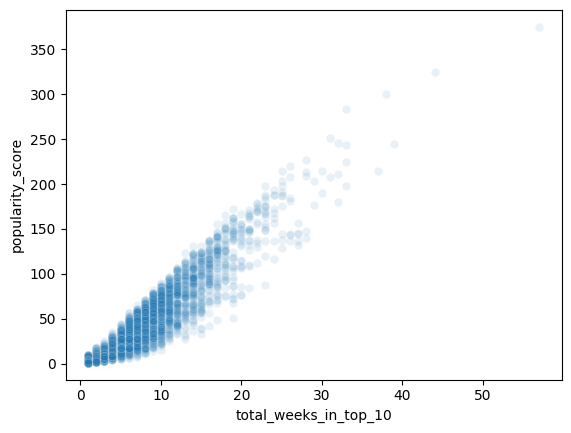

In [8]:
# Aggregate the songs using song_id, extracting the following metadata:
# - The total number of weeks the song was in the top 10 (ie the count of instances of the song_id)
# - The sum of the chart positions, using this formula: 11 - chart_position
popularity_agg_stats = songs_that_made_it_above_x.groupby('song_id').agg({
    'score_for_that_week': 'sum',
    'song_id': 'count'
}).rename(columns={
    'score_for_that_week': 'popularity_score',
    'song_id': 'total_weeks_in_top_10'
}).sort_values('total_weeks_in_top_10', ascending=False)

# plot the correlation using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# make a scatter plot with popularity_score and total_weeks_in_top_10
sns.scatterplot(data=popularity_agg_stats, x='total_weeks_in_top_10', y='popularity_score', alpha=0.1)




In [9]:
popularity_agg_stats

,popularity_score,total_weeks_in_top_10
song_id,,
Blinding LightsThe Weeknd,375,57
StayThe Kid LAROI & Justin Bieber,325,44
CirclesPost Malone,245,39
As It WasHarry Styles,300,38
Heat WavesGlass Animals,214,37
...,...,...
Like CrazyJimin,10,1
Life's A MessJuice WRLD X Halsey,2,1
Life Goes OnBTS,10,1


In [10]:
# to be double safe
first_instance_of_each_song = songs_that_made_it_above_x.sort_values('date_as_decimal').groupby(['song_id']).first().drop(columns=['index', 'chart_position', 'score_for_that_week'])

# merge
songs_df = first_instance_of_each_song.merge(
    popularity_agg_stats,
    left_index=True,
    right_index=True
)

assert(
    songs_df.shape[0] == len(songs_df.index.unique())
)

songs_df = songs_df.reset_index()
songs_df


,song_id,chart_debut,song,performer,date_as_decimal,popularity_score,total_weeks_in_top_10
0,#9 DreamJohn Lennon,1975-02-15,#9 Dream,John Lennon,1975.13,3,2
1,'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,2002-12-07,'03 Bonnie & Clyde,Jay-Z Featuring Beyonce Knowles,2002.93,56,11
2,'65 Love AffairPaul Davis,1982-04-24,'65 Love Affair,Paul Davis,1982.31,23,7
3,('til) I Kissed YouThe Everly Brothers,1959-09-07,('til) I Kissed You,The Everly Brothers,1959.68,44,7
4,(Can't Live Without Your) Love And AffectionNe...,1990-09-08,(Can't Live Without Your) Love And Affection,Nelson,1990.69,39,7
...,...,...,...,...,...,...,...
5136,amariJ. Cole,2021-05-29,amari,J. Cole,2021.41,6,1
5137,iSpyKYLE Featuring Lil Yachty,2017-04-01,iSpy,KYLE Featuring Lil Yachty,2017.25,31,8
5138,interludeJ. Cole,2021-05-22,interlude,J. Cole,2021.39,3,1
5139,"my.lifeJ. Cole, 21 Savage & Morray",2021-05-29,my.life,"J. Cole, 21 Savage & Morray",2021.41,9,1


### Export (so we can pull metadata for it in other notebooks)

In [11]:
songs_df.to_csv('../data/songs_df-through-Sep-2023.csv', index=False)

# 3. Merge in metadata: (a) individually split performers & their respective gender, (b) love song type

In [12]:
WITH_LOVE_SONG_TYPES_PATH = '../data/22.2-v3-OUTPUT-data-through-sep-2023-ALL-SONGS-LABELLED-with-good-riddance-corrections.csv'
love_song_types_table = pd.read_csv(WITH_LOVE_SONG_TYPES_PATH)[['song_id', 'love_song_sub_type']]

# We are not going to use Platonic Love in our analysis, so it becoomes a non love song
love_song_types_table['love_song_sub_type'] = love_song_types_table['love_song_sub_type'].apply(lambda x: np.nan if x == 'Platonic Love' else x)
love_song_types_table.love_song_sub_type.value_counts()

love_song_sub_type
Serenade                    1042
Longing & Heartbreak         828
It's Complicated             486
Courtship & Anticipation     446
Sexual Conquest              311
Good Riddance                125
Love Song for the Self       109
Name: count, dtype: int64

In [13]:
CORRECTED_PERFORMER_NAME_SPLITS_AND_GENDER_PATH = '../data/22.5-OUTPUT-2-corrected-name-splits-with_type_and_gender-SEP-2023-UPDATE.csv'
performer_split_and_gender_lookup_table = pd.read_csv(CORRECTED_PERFORMER_NAME_SPLITS_AND_GENDER_PATH).set_index('performer') # clever, no?
performer_split_and_gender_lookup_table


,performers_list_str,type_and_gender_list_str
performer,,
10cc,10cc|,gm|
ABBA,ABBA|,gx|
AWB,AWB|,gm|
Aaliyah,Aaliyah|,if|
Aaron Neville,Aaron Neville|,im|
...,...,...
Tom Clay,Tom Clay|,im|
Bill Black's Combo,Bill Black's Combo|,gm|
CJ,CJ|,im|


In [14]:
with_split_and_gender = songs_df.copy()
with_split_and_gender['performers_list_str'] = with_split_and_gender.performer.apply(lambda x: performer_split_and_gender_lookup_table.loc[x].performers_list_str)
with_split_and_gender['type_and_gender_list_str'] = with_split_and_gender.performer.apply(lambda x: performer_split_and_gender_lookup_table.loc[x].type_and_gender_list_str)
with_split_and_gender



# now merge with love love_song_types_table 
assert(len(with_split_and_gender) == len(love_song_types_table))
df = with_split_and_gender.merge(love_song_types_table, on='song_id')
df['love_song_sub_type'] = df.love_song_sub_type.replace({np.nan: 'none'})

assert(len(df) == len(df[df.performers_list_str.notnull()]))
assert(len(df) == len(df[df.type_and_gender_list_str.notnull()]))
# asssert there are no nans in the love_song_sub_type column
assert(len(df) == len(df[df.love_song_sub_type.notnull()]))
df

,song_id,chart_debut,song,performer,date_as_decimal,popularity_score,total_weeks_in_top_10,performers_list_str,type_and_gender_list_str,love_song_sub_type
0,#9 DreamJohn Lennon,1975-02-15,#9 Dream,John Lennon,1975.13,3,2,John Lennon|,im|,none
1,'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,2002-12-07,'03 Bonnie & Clyde,Jay-Z Featuring Beyonce Knowles,2002.93,56,11,Jay-Z|Beyonce|,im|if|,It's Complicated
2,'65 Love AffairPaul Davis,1982-04-24,'65 Love Affair,Paul Davis,1982.31,23,7,Paul Davis|,im|,none
3,('til) I Kissed YouThe Everly Brothers,1959-09-07,('til) I Kissed You,The Everly Brothers,1959.68,44,7,The Everly Brothers|,gm|,Serenade
4,(Can't Live Without Your) Love And AffectionNe...,1990-09-08,(Can't Live Without Your) Love And Affection,Nelson,1990.69,39,7,Nelson|,gm|,Longing & Heartbreak
...,...,...,...,...,...,...,...,...,...,...
5136,amariJ. Cole,2021-05-29,amari,J. Cole,2021.41,6,1,J. Cole|,im|,none
5137,iSpyKYLE Featuring Lil Yachty,2017-04-01,iSpy,KYLE Featuring Lil Yachty,2017.25,31,8,KYLE|Lil Yachty|,im|im|,Sexual Conquest
5138,interludeJ. Cole,2021-05-22,interlude,J. Cole,2021.39,3,1,J. Cole|,im|,none
5139,"my.lifeJ. Cole, 21 Savage & Morray",2021-05-29,my.life,"J. Cole, 21 Savage & Morray",2021.41,9,1,J. Cole|21 Savage|Morray|,im|im|im|,none


# Export to Svelte App

In [15]:
viz_export_ready_df = df[[
    # 'performer', 
    'performers_list_str', # using this parsaable list of performers instead
    'song', 
    # 'generic_genre', # drop genre for now
    #'gender', # we have a sub-artist specific granularity for now
    # 'type_and_gender_list_str', # NOTE: we ended up not using this in the app
    'date_as_decimal', 'love_song_sub_type', 
    # 'popularity_score', 
    'total_weeks_in_top_10'
]]

# Rename Platonic Love to 'none' (since we don't decided not to keep it as a love song sub type)
viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('Platonic Love', 'none')

# Now, make it skinnier
viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('none', '')

# Now, create a dictionary that can serve a key so that we can replace love song types with numbers (to keep the json small)
love_song_sub_type_dict = {col: i for i, col in enumerate(viz_export_ready_df.love_song_sub_type.unique())}
# Now replace love song types with numbers
viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace(love_song_sub_type_dict)
# Now create reverse the keys and vals so that we can use the numbers to look up the love song types
enum_to_love_song_sub_type_dict = {v: k for k, v in love_song_sub_type_dict.items()}

viz_export_ready_df.date_as_decimal = viz_export_ready_df.date_as_decimal.round(2)

viz_export_ready_df = viz_export_ready_df.sort_values('date_as_decimal')

viz_export_ready_df.to_json(
    '../data/pop-love-songs-data-through-september-2023.json',
    orient="values",
)

# GENERATE A KEY since we're just using index to keep the json small
print({col: i for i, col in enumerate(viz_export_ready_df.columns)})
print(enum_to_love_song_sub_type_dict)

viz_export_ready_df.love_song_sub_type.value_counts()

{'performers_list_str': 0, 'song': 1, 'date_as_decimal': 2, 'love_song_sub_type': 3, 'total_weeks_in_top_10': 4}
{0: '', 1: "It's Complicated", 2: 'Serenade', 3: 'Longing & Heartbreak', 4: 'Courtship & Anticipation', 5: 'Sexual Conquest', 6: 'Love Song for the Self', 7: 'Good Riddance'}


/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_5748/2979333000.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('Platonic Love', 'none')
/var/folders/b7/c67wpzpn25q0h072y9mmz_th0000gn/T/ipykernel_5748/2979333000.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viz_export_ready_df.love_song_sub_type = viz_export_ready_df.love_song_sub_type.replace('none', '')
/var/folders/b7/c67wpzpn25q0h072y9mmz_th000

love_song_sub_type
0    1794
2    1042
3     828
1     486
4     446
5     311
7     125
6     109
Name: count, dtype: int64